In [1]:
import regex as re
import numpy as np
import torch
import torch.nn as nn
import pickle
from torch.utils.data import DataLoader
from Autoencoder import Autoencoder
from Analyse import Analyse
from LanguageVectoriser import LanguageVectoriser
from TextCleaner import TextClean

In [2]:
# variables

stop_words = ['a','in','on','at','and','or', 'but', 'my', 'ive', '...',
              'to', 'the', 'of', 'an', 'by', 'theyre', 'if', 'our', 'am',
              'as', 'is', 'was', 'were', 'been', 'be', 'your', 'weve', 'thats',
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'also',
             'it', 'he', 'she', 'we', 'they' 'will', 'have', 'has', 'id',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 'me', 'us',
             'his', 'her', 'they', 'them', 'from', 'with', 'its', "it's", 
              'into', 'when', 'so', 'there', 'him', 'because', 'im', 'hes',
              'youre', 'too', 'oh', 'their', 'youve',
              'things', 'youll', 'how', 'yes', 'theres', 'ill', 'like', 
              'one', 'here', 'all', 'any', 'say', 'around', 'two', 'than', 
              'before', 'up', 'just', 'now', 'still', 'where', 'go',
              'whats', 'then', 'would', 'about', 'had',
              'get', 'got', 'many', 'will', 'either', 
              'probably', 'lot', 'such', 'itself', 'absolutely', 
              'seems', 'within', 'second', 'give', 'always', 'everything', 'both', 'change', 
              'ok', 'mine', 'especially', 'highly', 'i’ve', 'side', 
              'different', 'needed', 'thought', 'already', 'made', 'wanted', 'though', 
              'done', 'same', 'see', 'while', 'going', 'tell', 'over', 'however', 'exactly',
              'definitely', 'behind', 'thing', 'etc', 'way', 'sure', 'back', 'make', 
              'name', 'being', 'every', 'think', 'yet', 'day', 'through', 'item', 
              'makes', 'i’m', 'come', 'once', 'took', 'full', 'says', 'i’m', 'again', 
              'down', 'having', 'after', 'few', 'via', 'other', 'does', 'really', 'use', 
              'bit', 'it’s', 'find', 'comes', 'try', 'right', 'soon', 'each', 'goes',
              'echo', 'dot', 'dots', 'amazon', 'even' 'device', 'fire', 'tablet', ' ', 'very',
              'bought', 'buy', 'set', '  ', 'only', 'want', 'little', 'much', 'even',
              'easy &amp;', 'new kindle', 'hd 7', 'old kindle', 'year old', 'kindle more',
              'no longer', 'apps not', 'life not', 'some reason', 'not great', 'more expensive',
              'pretty good', 'far good', 'not know', 'look forward', 'certainly not', 'problem not', 
              'great need', 'screen no', 'something else', '2 hours', 'more more',
              'better more', 'not good', 'well great', 'almost good', 'youd expect']
verbose = False
TFIDF = True
use_phrases = True
glove = False
ratings_to_analyse = [1, 2, 3, 4, 5]
emb_size = 300
phrase_lens = [2]
min_df = 3
max_df = 3000
keep_top_n = 1000
batch_size = 20
max_epochs = 200
criterion = nn.MSELoss()
lr = 0.0005
weight_decay = 0.00001

In [3]:
# open reviews and ratings and store in lists

with open("reviews", "rb") as fp:
    reviews_dict = pickle.load(fp)

star_ratings = []
reviews = []
for rating in reviews_dict:
    star_ratings += reviews_dict[rating][1]
    reviews += reviews_dict[rating][0]
star_ratings = np.reshape(np.array(star_ratings), (len(star_ratings), 1))

print(f'Number of reviews scraped: {len(reviews)}')

Number of reviews scraped: 13450


In [4]:
# clean reviews

cleaner = TextClean(stop_words=stop_words, verbose=verbose, use_phrases=use_phrases, phrase_lens=phrase_lens)
cleaned_reviews, star_rating = cleaner.clean_up(reviews, star_ratings, ratings_to_analyse, verbose)

In [5]:
# vectorise reviews

vectoriser = LanguageVectoriser(total_texts=len(cleaned_reviews))
vocab, df_counts, ngram_counts, id_to_word, word_to_id = vectoriser.extract_vocab(cleaned_reviews, min_df, max_df, keep_top_n)
vectorised_reviews, star_ratings = vectoriser.vectorise(cleaned_reviews, star_ratings, vocab, 
                                                        df_counts, ngram_counts, TFIDF, 
                                                        glove, emb_size, ratings_to_analyse)
print(f'Number of reviews to train on after cleaning: {len(vectorised_reviews)}')

Number of reviews to train on after cleaning: 9806


Average loss per text at epoch number 20 : 1.0328
Average loss per text at epoch number 40 : 0.9657
Average loss per text at epoch number 60 : 0.9519
Average loss per text at epoch number 80 : 0.9406
Average loss per text at epoch number 100 : 0.9322
Average loss per text at epoch number 120 : 0.9254
Average loss per text at epoch number 140 : 0.9194
Average loss per text at epoch number 160 : 0.9137
Average loss per text at epoch number 180 : 0.9092


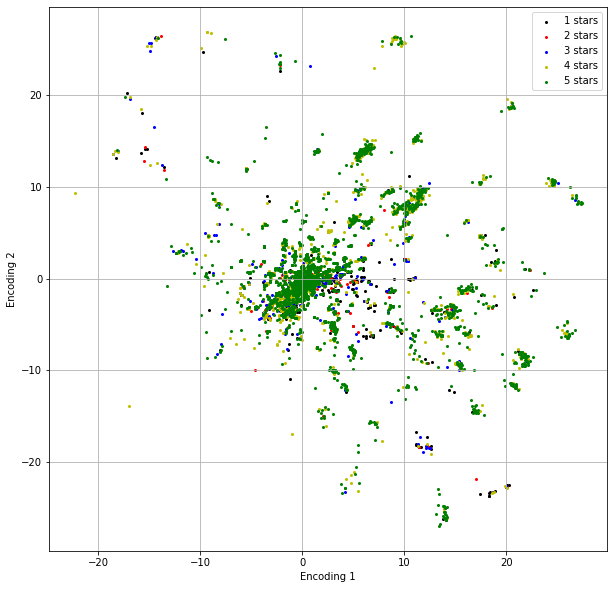

In [7]:
# train autoencoder

torch.manual_seed(200206323)
AE = Autoencoder(vector_len=len(vocab))
scaled_text, scaler = AE.scaler(vectorised_reviews)
optimizer = torch.optim.Adam(AE.parameters(), lr=lr, weight_decay=weight_decay)
trainloader = torch.utils.data.DataLoader(scaled_text, batch_size=batch_size, shuffle=True)
running_loss = 0
for epoch in range(max_epochs):
    for batch in trainloader:
        optimizer.zero_grad()
        estimate = AE(batch.clone().detach().requires_grad_(True).float())
        loss = criterion(estimate, batch.clone().detach().requires_grad_(True).float())
        loss.backward()
        optimizer.step()
        loss = loss.item()
        running_loss += loss
    if epoch % 20 == 0 and epoch > 0:
        ave_loss = round(running_loss / (20 * (vectorised_reviews.shape[0] / batch_size)), 4)
        print(f'Average loss per text at epoch number {epoch} : {ave_loss}')
        running_loss = 0

# create encodings and view
encodings = AE.create_encodings(scaled_text)
AE.plot_encodings(encodings, star_ratings)

In [14]:
# choose cluster on 2D graph to analyse

analysis = Analyse( vocab=vocab, 
                    encodings=encodings,  
                    scaler=scaler,
                    classifier=star_ratings,
                    vectorised_texts=vectorised_reviews,
                    df_count=df_counts,
                    word_to_id = word_to_id)
num_topics = 30

### change encoding values to look at topics in different cluster ###
encoding = [22, -9]
topic_list = analysis.topic_extractor(encoding, num_topics)

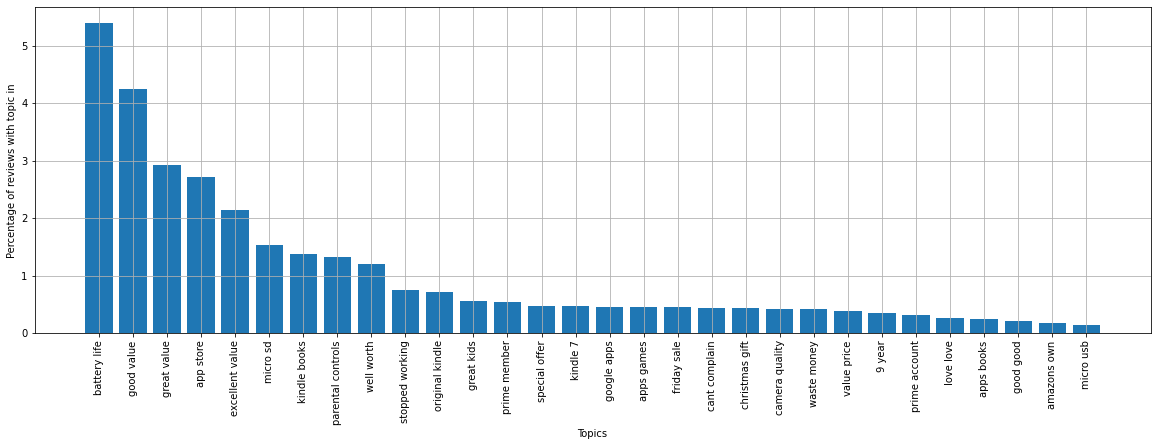

In [15]:
analysis.topic_popularity_display(topic_list)

Star rating distribution for each topic (rated 1 star to 5 star)



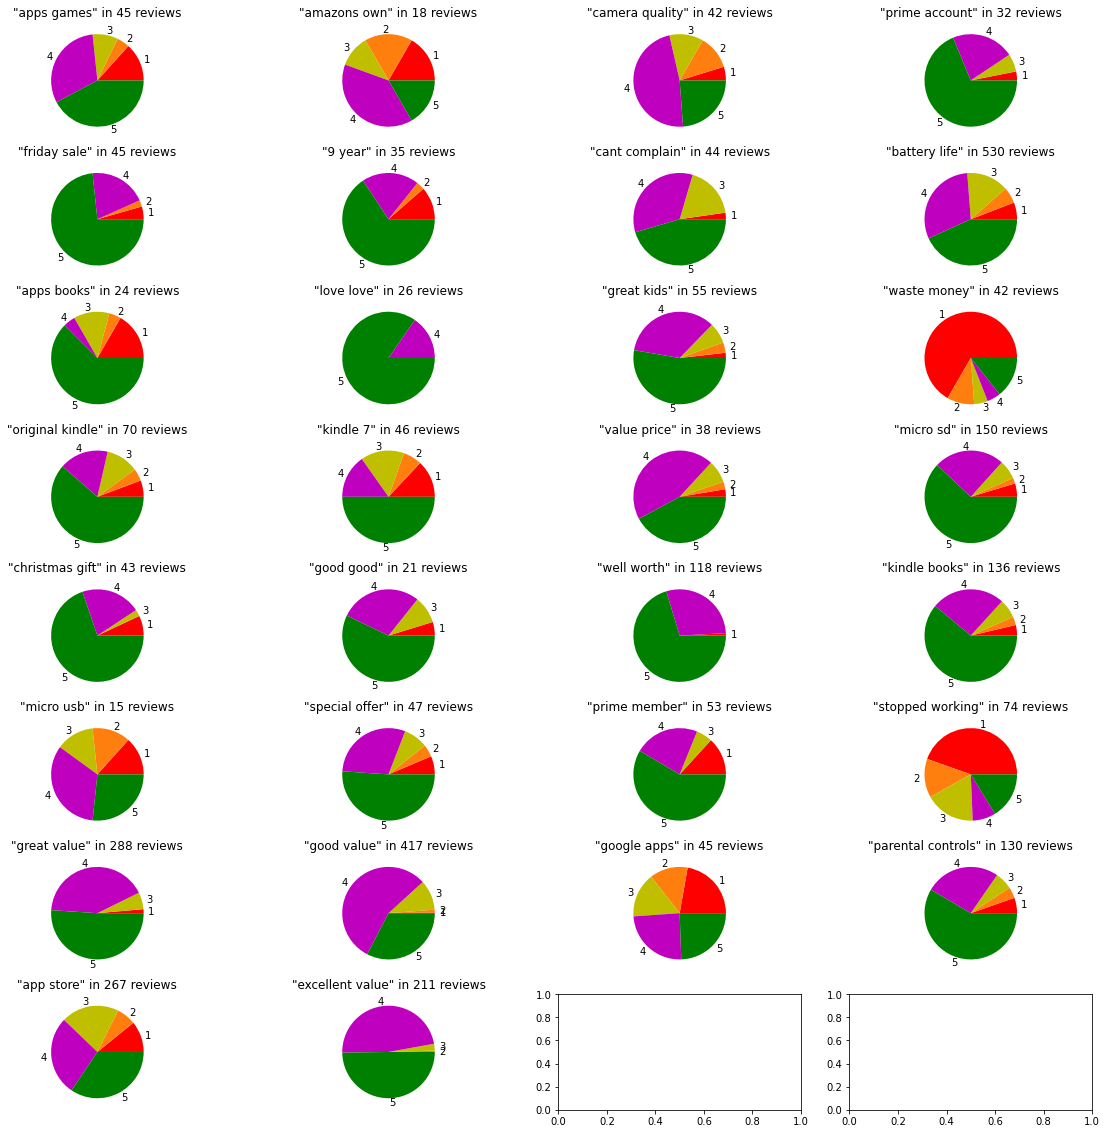

In [16]:
analysis.topic_rating_distribution(topic_list)